In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.experiment import Experiment
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, gaussian_remesh, select_LatLon, Lk_error, x_coord, y_coord, filter_apply, filter_iteration
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

# Componentwise check of every array

In [79]:
exp = Experiment('/scratch/pp2681/mom6/regression_tests/testing_offline')

In [80]:
from xgcm import Grid
grid = Grid(exp.mom, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            }
            )

In [3]:
# def compare(online = exp.mom.sh_xx,offline=exp.sh_xx(), zl=0, vmax=None):
#     plt.figure(figsize=(12,3))
#     plt.subplot(1,3,1)
#     online.isel(zl=zl).plot()
#     plt.title('online')
#     plt.subplot(1,3,2)
#     offline.isel(zl=zl).plot()
#     plt.title('offline')
#     plt.title('')
#     plt.subplot(1,3,3)
#     (online-offline).isel(zl=zl).plot(vmax=vmax)
#     plt.title('difference')
#     plt.tight_layout()

In [84]:
# compare()

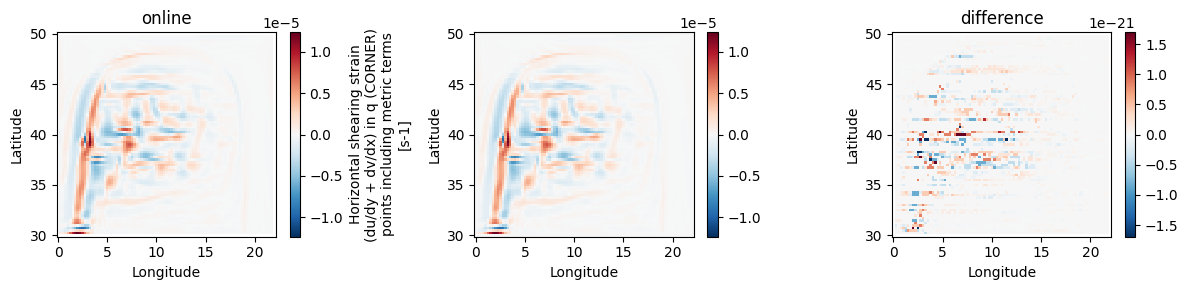

In [47]:
compare(exp.mom.sh_xy, exp.sh_xy(),zl=0)

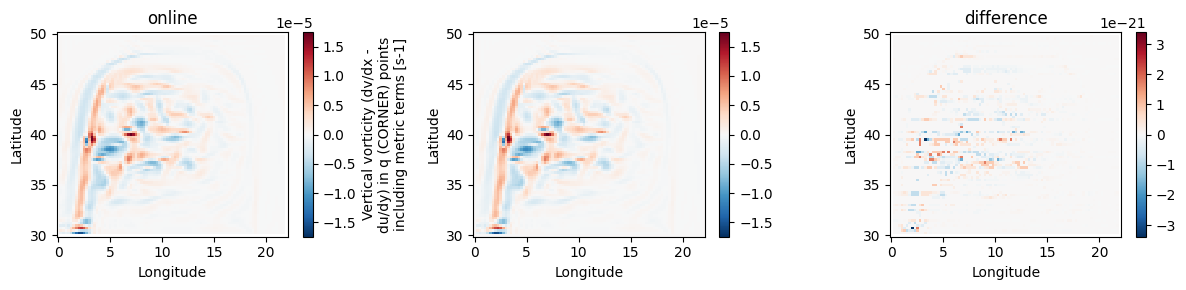

In [48]:
compare(exp.mom.vort_xy, exp.vort_xy(),zl=0)

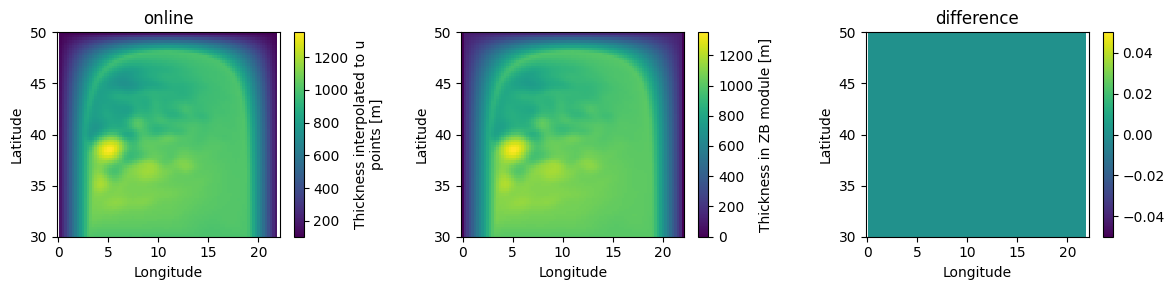

In [72]:
compare(exp.mom.h_u, exp.h_u,zl=0)

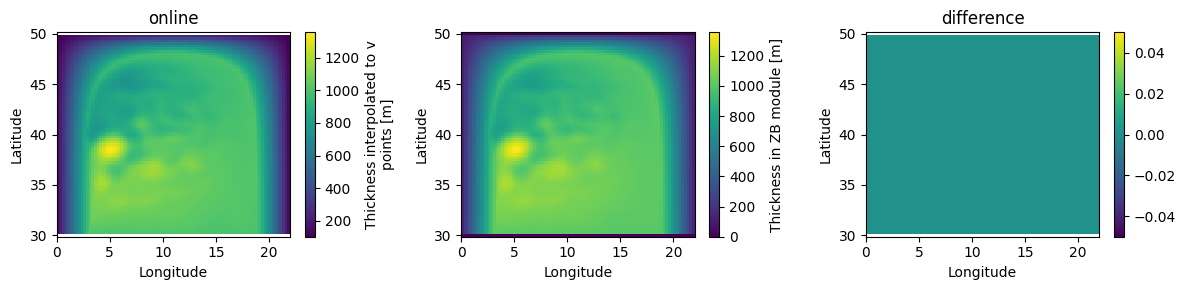

In [50]:
compare(exp.mom.h_v, exp.h_v,zl=0)

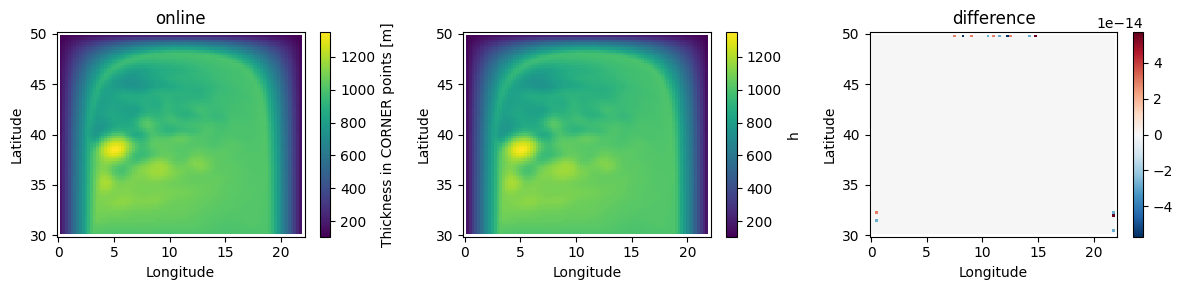

In [51]:
compare(exp.mom.hq, exp.hq,zl=0)

In [52]:
amp = 1.0
sh_xx = exp.mom.sh_xx
vort_xy = exp.mom.vort_xy
sh_xy = exp.mom.sh_xy
h_u = exp.mom.h_u
h_v = exp.mom.h_v
hq = exp.mom.hq

areaBu = exp.param.dxBu * exp.param.dyBu
areaT = exp.param.dxT * exp.param.dyT

sum_sq = 0.5 * (remesh(vort_xy,exp.h)**2+remesh(sh_xy,exp.h)**2+sh_xx**2)
vort_sh = remesh(vort_xy,exp.h) * remesh(sh_xy,exp.h)

k_bc = - amp * areaT
S_11 = k_bc * (- vort_sh + sum_sq)
S_22 = k_bc * (+ vort_sh + sum_sq)
k_bc =  - amp * areaBu
S_12 = k_bc * vort_xy * remesh(sh_xx,vort_xy)

Txx = S_11 * exp.h
Tyy = S_22 * exp.h
Txy = S_12 * exp.mom.hq

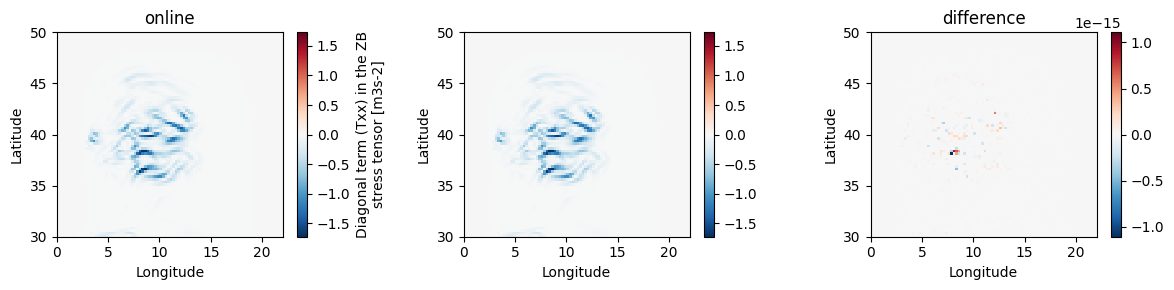

In [59]:
compare(exp.mom.Txx,Txx, zl=1)

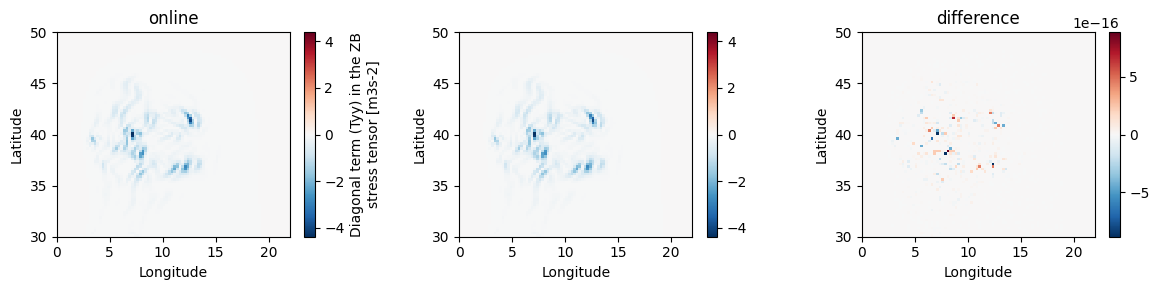

In [60]:
compare(exp.mom.Tyy,Tyy, zl=1)

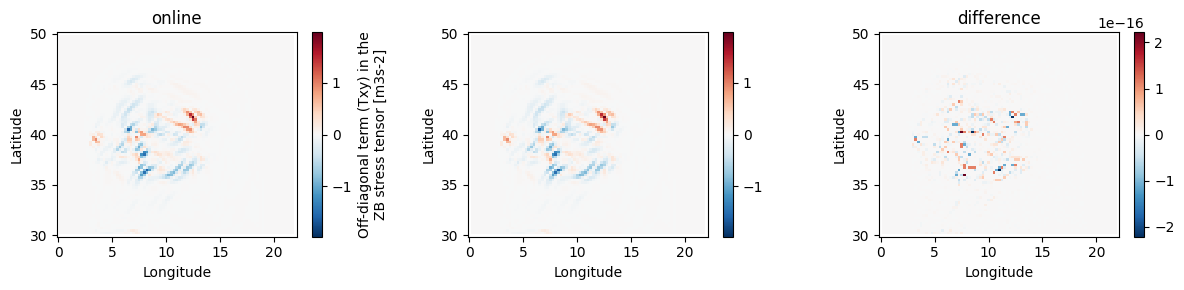

In [61]:
compare(exp.mom.Txy,Txy,zl=1)

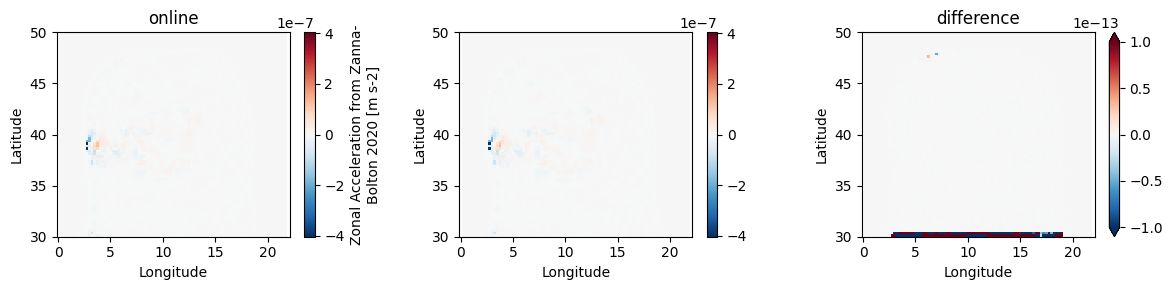

In [62]:
compare(exp.mom.ZB2020u,exp.ZB_offline(ZB_cons=0)[0],zl=1, vmax=1e-13)

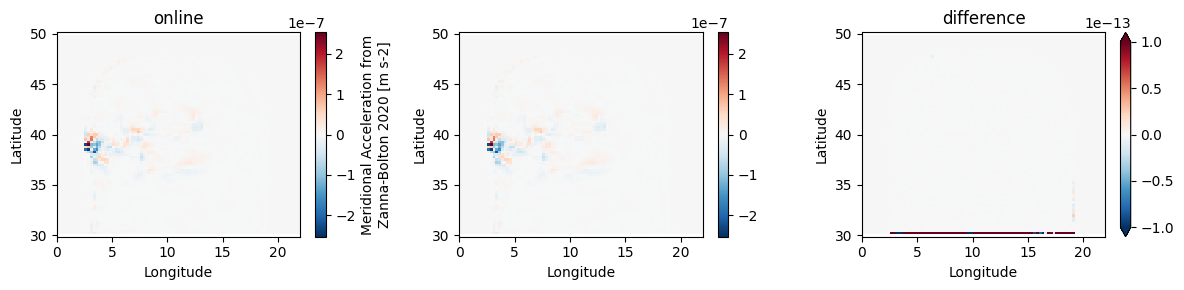

In [65]:
compare(exp.mom.ZB2020v,exp.ZB_offline(ZB_cons=0)[1],zl=1, vmax=1e-13)

# Check boundary condition on NW2 configuration
Note that placing b.c. inside the xgcm is not needed because we implement all B.C. with masks as in MOM6

In [ ]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()

In [3]:
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

In [4]:
from xgcm import Grid
grid = Grid(mom, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            },
            periodic = 'X'
            )

In [5]:
# Physical B.C.: no-normal flow;
# We apply it by multiplying with wet_u and wet_v
dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
print(dudx.shape)
print(dvdy.shape)

(15, 280, 120)
(15, 280, 120)


In [6]:
# Physical B.C.: free-slip, i.e. du/dy=0 on the boundary;
# We apply it by multiplying the result by the mask
dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c

print(dudy.shape)
print(dvdx.shape)

(15, 281, 121)
(15, 281, 121)


In [7]:
sh_xx = dudx-dvdy
sh_xy = dvdx+dudy
vort_xy=dvdx-dudy

In [2]:
# We compare masked fields because outside there may be 1e+20 values
def compare(online, offline, mask, zl=-1, vmax=None):
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    (online*mask).isel(zl=zl).plot()
    plt.title('online')
    plt.subplot(1,3,2)
    (offline*mask).isel(zl=zl).plot()
    plt.title('offline')
    plt.subplot(1,3,3)
    np.abs((online-offline)*mask).isel(zl=zl).plot(vmax=vmax)
    plt.title('difference')
    plt.tight_layout()
    error = ((online-offline)*mask)
    print('Error:', float((error**2).sum()))
    print('Nans:', int(np.sum(np.isnan(error))))

9.884383167880741e-38


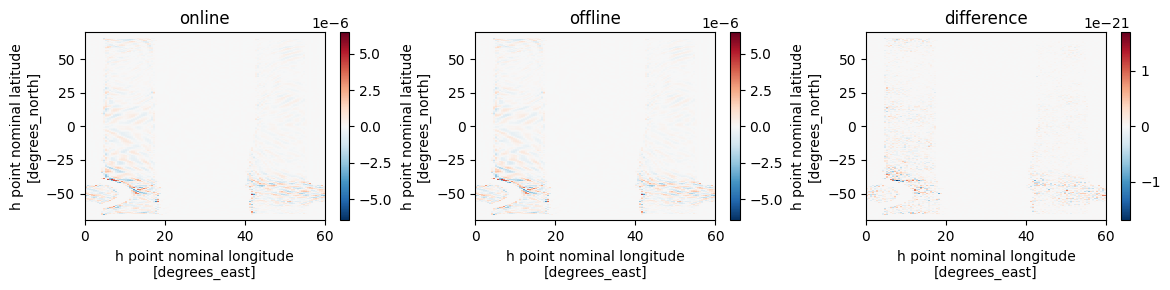

In [9]:
compare(mom.sh_xx, sh_xx, param.wet, zl=-1)

1.1468308175247153e-37


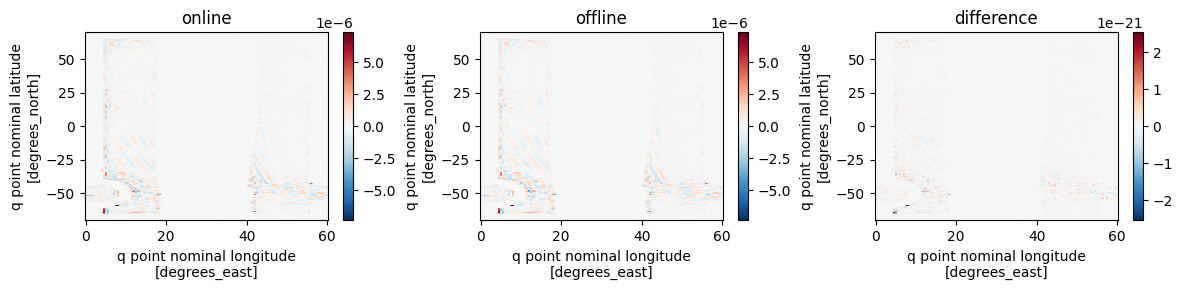

In [10]:
compare(mom.sh_xy, sh_xy, param.wet_c, zl=-1)

1.2896248487818291e-37


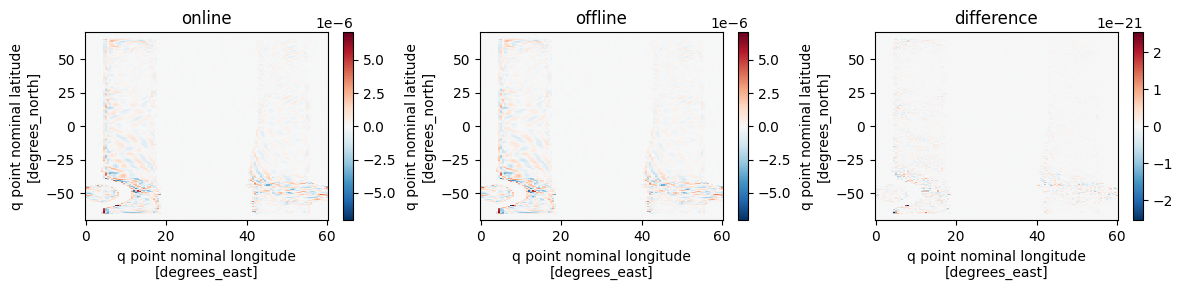

In [11]:
compare(mom.vort_xy, vort_xy, param.wet_c, zl=-1)

In [12]:
# Physical B.C.: vort_xy and sh_xy are zero on the boundary (q-points).
# Because we already applied masks,
# the interpolation to h-points is possible without additional manipulations
vort_xy_center = grid.interp(vort_xy,['X','Y'])
sh_xy_center = grid.interp(sh_xy,['X','Y'])

In [13]:
# Physical B.C.: corner points are on the boundaries. Thus, we need to place the boundary condition.
# We do it by multiplying with wet_c
sh_xx_corner = grid.interp(sh_xx,['X', 'Y']) * param.wet_c

In [14]:
vort_sh = vort_xy_center * sh_xy_center
sum_sq = 0.5 * (vort_xy_center**2 + sh_xy_center**2 + sh_xx**2)
Txx = - param.area_t * (- vort_sh + sum_sq)
Tyy = - param.area_t * (+ vort_sh + sum_sq)
Txy = - param.area_q * (vort_xy * sh_xx_corner)

In [15]:
# Physical B.C.: According to MOM6 code, the best physical B.C. is to say that thickness is zero on the boundary
# Thus, the thickness on the boundary face is not zero; Actually, it should not be zero as in Double Gyre in Southern part
# We apply it with mask
h_u = grid.interp(mom.h * param.wet, 'X')
h_v = grid.interp(mom.h * param.wet, 'Y')

In [16]:
# # Operator h_u[j]*h_u[j+1]
# from xgcm import apply_as_grid_ufunc
# def prod_1d(a):
#     return a[...,1:]*a[...,:-1]

# def prod_axis(a, axis):
#     return np.apply_along_axis(prod_1d, axis, a)

# def prod_u_Y(h_u):
#     axis = h_u.get_axis_num('yh')
#     result = mom.Txy * 0
#     result[:,1:-1,:] = prod_axis(h_u, axis)
#     return result

# def prod_v_X(h_v):
#     axis = h_v.get_axis_num('xh')
#     result = mom.Txy * 0
#     result[:,:,1:-1] = prod_axis(h_v, axis)
#     return result

In [17]:
# simplest operators for a while
def prod_u_Y(a):
    b = a.pad({'yh': (1,1)}, mode='constant', constant_values=(1e+20,1e+20)).rename({'yh': 'yq'}).drop_vars(['yq'])
    return b[:,1:,:] * b[:,:-1,:]
def prod_v_X(a):
    b = a.pad({'xh': (1,1)}, mode='wrap').rename({'xh': 'xq'}).drop_vars(['xq'])
    return b[:,:,1:] * b[:,:,:-1]    

In [18]:
# Here we assume that h_u and h_v "well defined" on the boundaries. Actually, they are defined somehow.
# One can check, that both arrays (h_u, h_v) are zero on land. The interpolation rule with multiplication leads to zero on the
# boundary (in most cases)
h2uq = 4.0 * prod_u_Y(h_u)
h2vq = 4.0 * prod_v_X(h_v)
h_neglect3 = 1e-70
hq = (2 * h2uq * h2vq) / (h_neglect3 + (h2uq+h2vq) * 2 * (grid.interp(h_u,'Y') + grid.interp(h_v,'X')))

0.0


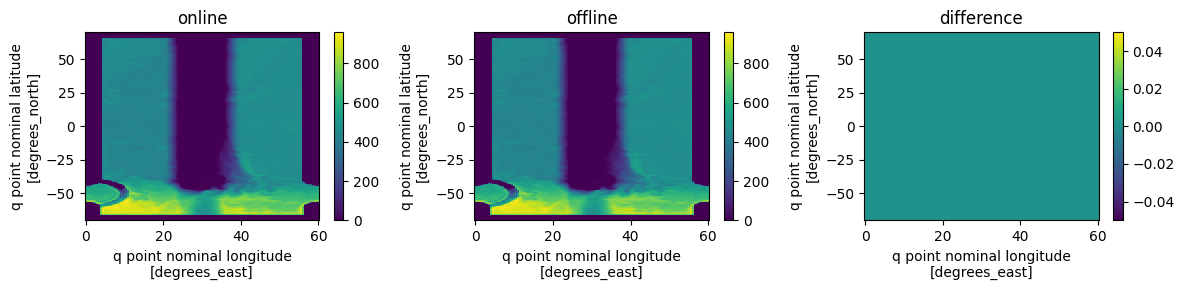

In [19]:
compare(mom.hq, hq, param.wet_c, zl=-3)

In [20]:
TTxx = Txx * mom.h
TTyy = Tyy * mom.h
TTxy = Txy * hq

3.546714216144006e-25


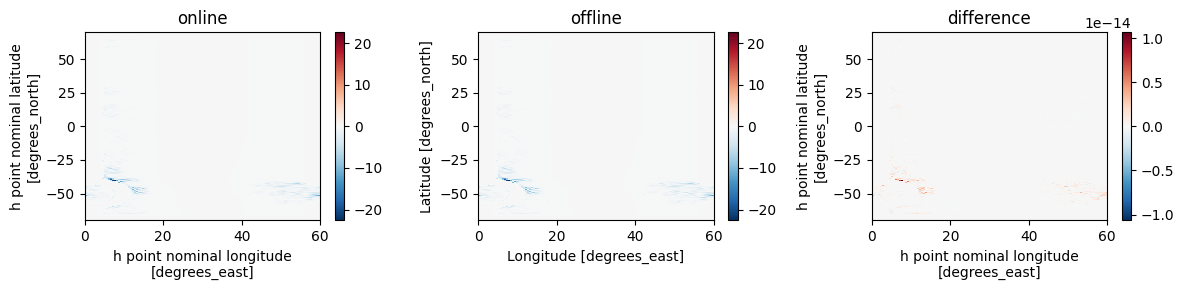

In [21]:
compare(mom.Txx, TTxx, param.wet, zl=-1)

4.835362798351786e-25


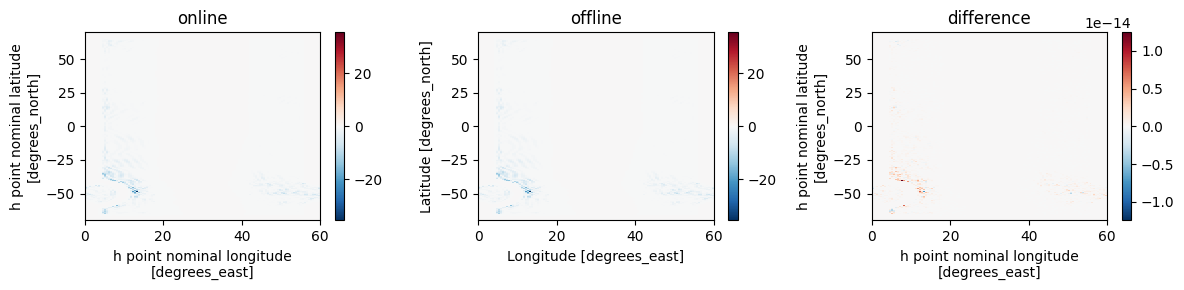

In [22]:
compare(mom.Tyy, TTyy, param.wet, zl=-1)

6.554675610533594e-26


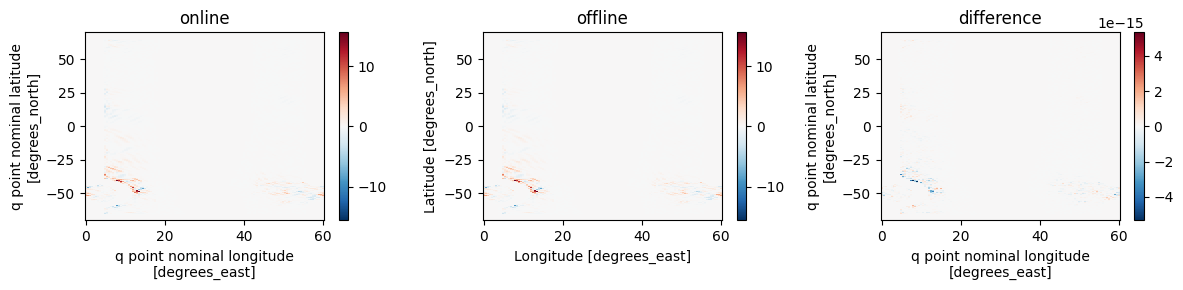

In [23]:
compare(mom.Txy, TTxy, param.wet_c, zl=-1)

In [24]:
# Physical B.C. for Txx and Tyy are not required: they contribute only to inner points do to no-flow condition on velocity
# Physical B.C. on Txy is required: it should be zero on boundary. However, we already applied this B.C. to:
# vort_xy, sh_xx_corner and hq is zero on boundary. So, B.C. are not required
ZB2020u = (grid.diff(TTxx*param.dyT**2, 'X') / param.dyCu     \
           + grid.diff(TTxy*param.dxBu**2, 'Y') / param.dxCu) \
           / (param.dxCu*param.dyCu) / (h_u+1e-70)

ZB2020v = (grid.diff(TTxy*param.dyBu**2, 'X') / param.dyCv     \
           + grid.diff(TTyy*param.dxT**2, 'Y') / param.dxCv) \
           / (param.dxCv*param.dyCv) / (h_v+1e-70)

4.172315862486437e-37


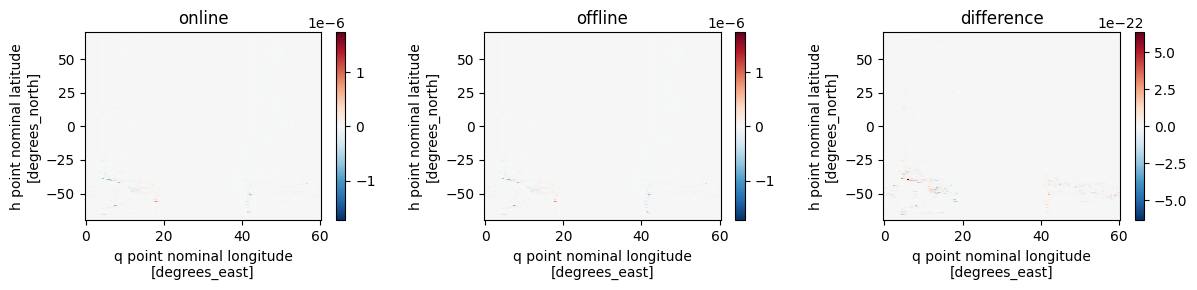

In [25]:
compare(mom.ZB2020u, ZB2020u, param.wet_u, zl=-1)

2.76467793759674e-37


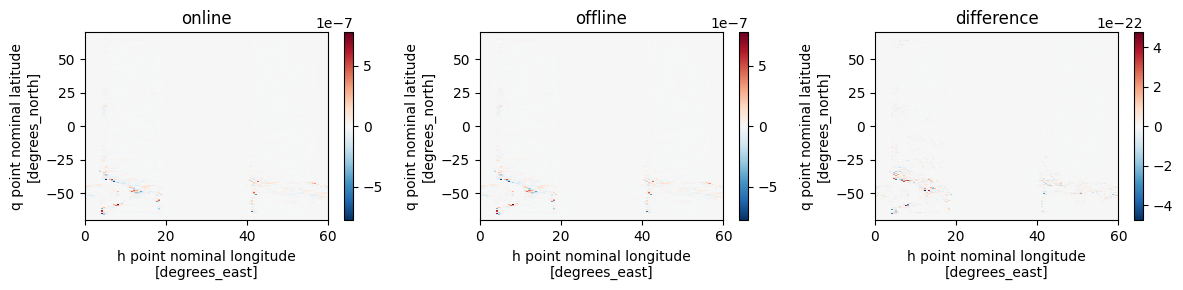

In [26]:
compare(mom.ZB2020v, ZB2020v, param.wet_v, zl=-1)

# Check a single function

In [108]:
import xgcm ;xgcm.__version__

'0.8.1'

In [51]:
from xgcm import Grid
def check_nans(x, message):
    if np.isnan(x).sum() > 0:
        print('NaNs in ', message)
def Zanna_Bolton(mom,param,Stress_iter=0,R_diss=-1,HPF_iter=0, ZB_type=0, ZB_cons=0, k_bc=-1, amplitude=1, Txy_only=False, double_counting=True):
    grid = Grid(param, coords={
                'X': {'center': 'xh', 'outer': 'xq'},
                'Y': {'center': 'yh', 'outer': 'yq'}
                },
                boundary={'X':'periodic', 'Y':'fill'},
                fill_value = {'X':1e+20, 'Y':1e+20}
                )
    check_nans(mom.u, 'u')
    check_nans(mom.u, 'v')
    
    dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
    dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
    
    dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
    dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c
    
    check_nans(dudx, 'dudx')
    check_nans(dvdy, 'dvdy')
    check_nans(dudy, 'dudy')
    check_nans(dudx, 'dudx')
    
    sh_xx = dudx-dvdy
    sh_xy = dvdx+dudy
    vort_xy=dvdx-dudy
    
    if R_diss > 0:
        shear = np.sqrt(sh_xx**2 + grid.interp(sh_xy**2 + vort_xy**2, ['X', 'Y']))
        coriolis = np.abs(
                grid.interp(param.Coriolis, ['X', 'Y'])
                ) + 1e-30
        c_diss = 1 / (1 + shear / (coriolis * R_diss) )
    else:
        c_diss = sh_xx*0 + 1
    
    if HPF_iter > 0:
        sh_xx0 = sh_xx.copy()
        sh_xy0 = sh_xy.copy()
        vort_xy0 = vort_xy.copy()
        for i in range(HPF_iter):
            sh_xx = param.wet * filter_apply(sh_xx * param.wet, x_periodic=True)
            sh_xy = param.wet_c * filter_apply(sh_xy * param.wet_c,x_periodic=True)
            vort_xy = param.wet_c * filter_apply(vort_xy * param.wet_c,x_periodic=True)
        sh_xx = sh_xx0 - sh_xx
        sh_xy = sh_xy0 - sh_xy
        vort_xy = vort_xy0 - vort_xy
    
    vort_xy_center = grid.interp(vort_xy,['X','Y'])
    sh_xy_center = grid.interp(sh_xy,['X','Y'])
    sh_xx_corner = grid.interp(sh_xx,['X', 'Y']) * param.wet_c
    
    if (ZB_cons == 0):
        vort_sh = vort_xy_center * sh_xy_center
    elif (ZB_cons == 1):
        vort_sh = grid.interp(param.area_q * vort_xy * sh_xy, ["X", "Y"]) / (param.area_t+1e-70)
    elif (ZB_cons == 2):
        vort_sh = grid.interp(vort_xy * sh_xy, ["X", "Y"])
    elif (ZB_cons == 3):
        vort_sh = grid.interp(param.area_q**2 * vort_xy * sh_xy, ["X", "Y"]) / (param.area_t**2+1e-70)
    else:
        print('Error: wrong ZB_cons')
        
    sum_sq = 0.5 * (vort_xy_center**2 + sh_xy_center**2 + sh_xx**2)
    if (ZB_type == 1):
        sum_sq = 0 * sum_sq
    if (ZB_type == 2):
        vort_sh = 0 * vort_sh
        
    if k_bc<0:
        kappa_t = param.area_t * param.wet * amplitude
        kappa_q = param.area_q * param.wet_c * amplitude
    else:
        kappa_t = k_bc * param.wet
        kappa_q = k_bc * param.wet_c
        
        
    Txx = - kappa_t * (- vort_sh + sum_sq)
    Tyy = - kappa_t * (+ vort_sh + sum_sq)
    Txy = - kappa_q * (vort_xy * sh_xx_corner)
    
    if Txy_only:
        Txx = Txx * 0
        Tyy = Tyy * 0
    
    if (ZB_type == 2):
        Txy = Txy * 0
    
    h_u = grid.interp(mom.h * param.wet, 'X')
    h_v = grid.interp(mom.h * param.wet, 'Y')

    from xgcm.grid_ufunc import as_grid_ufunc
    @as_grid_ufunc(signature="(X:center)->(X:outer)", boundary_width={'X':(1,1)})
    def prod_ufunc(a):
        return a[...,:-1] * a[...,1:]
    
    h2uq = 4.0 * prod_ufunc(grid, h_u, axis='Y') #prod_u_Y(h_u)
    h2vq = 4.0 * prod_ufunc(grid, h_v, axis='X')#prod_v_X(h_v)
    h_neglect3 = 1e-70
    hq = (2 * h2uq * h2vq) / (h_neglect3 + (h2uq+h2vq) * 2 * (grid.interp(h_u,'Y') + grid.interp(h_v,'X')))
    
    for i in range(Stress_iter):
        Txx = param.wet * filter_apply(Txx * param.wet, x_periodic=True)
        Tyy = param.wet * filter_apply(Tyy * param.wet, x_periodic=True)
        Txy = param.wet_c * filter_apply(Txy * param.wet_c,x_periodic=True)

    TTxx = Txx * mom.h * c_diss
    TTyy = Tyy * mom.h * c_diss
    TTxy = Txy * hq * grid.interp(c_diss, ['X', 'Y'])
    
    ZB2020u = (grid.diff(TTxx*param.dyT**2, 'X') / param.dyCu     \
           + grid.diff(TTxy*param.dxBu**2, 'Y') / param.dxCu) \
           / (param.dxCu*param.dyCu) / (h_u+1e-70)

    ZB2020v = (grid.diff(TTxy*param.dyBu**2, 'X') / param.dyCv     \
               + grid.diff(TTyy*param.dxT**2, 'Y') / param.dxCv) \
               / (param.dxCv*param.dyCv) / (h_v+1e-70)
    
    KE_source = (grid.interp(param.wet_u * mom.u * h_u * param.area_u * ZB2020u, "X") + \
                 grid.interp(param.wet_v * mom.v * h_v * param.area_v * ZB2020v, "Y")) * param.wet
    
    Px_source = param.wet_u * h_u * param.area_u * ZB2020u
    Py_source = param.wet_v * h_v * param.area_v * ZB2020v
    if not double_counting:
        Px_source[{'xq':0}] = 0 # This is repeating point due to B.C.
    
    return {'ZB2020u': ZB2020u, 'ZB2020v': ZB2020v, 
            'Txx': Txx, 'Tyy': Tyy, 'Txy': Txy, 
            'TTxx': TTxx, 'TTyy': TTyy, 'TTxy': TTxy, 
            'c_diss': c_diss, 
            'sh_xx': sh_xx, 'sh_xy': sh_xy, 'vort_xy': vort_xy,
            'hq' : hq, 'KE_source': KE_source, 
            'Px_source': Px_source, 'Py_source': Py_source}

# Padding

In [139]:
grid = Grid(param, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            },
           boundary={"X": 'fill', 'Y': 'fill'},
           fill_value=1e+20)
from xgcm.padding import pad
pad(dim.h*0 + 2, grid, boundary_width={'Y':(1,1)}).isel(zl=0,xh=10)

<xarray.DataArray 'h' (yh: 82)>
array([1.e+20, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00, 2.e+00,
       2.e+00, 1.e+20])
Dimensions without coordinates: yh

In [33]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030003.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

In [36]:
# compare(mom.ZB2020u, Zanna_Bolton(mom,param,4, R_diss=1.0)['AB2020u'], param.wet_u, zl=-1)

Error: 2.8013479558947984e-38
Nans: 0


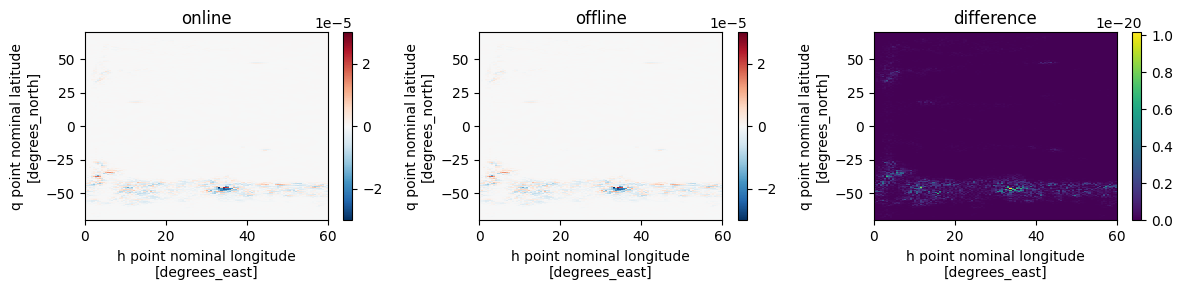

In [36]:
compare(mom.ZB2020v, Zanna_Bolton(mom,param,4, R_diss=1.0)[1], param.wet_v, zl=3)

Error: 3.0641969119788688e-28
Nans: 0


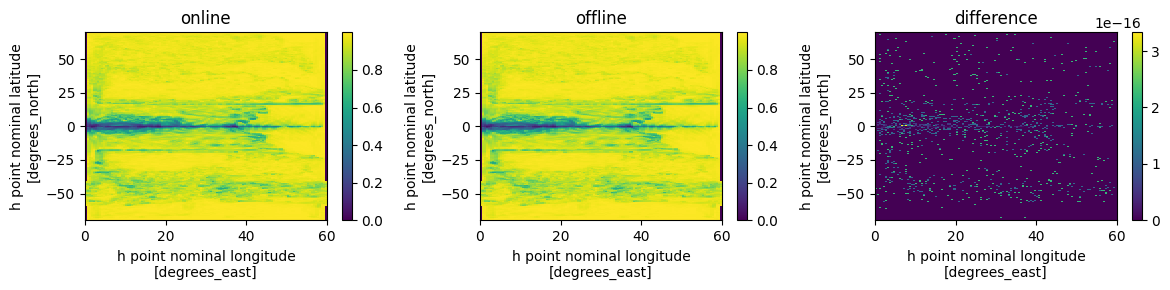

In [37]:
c_diss = Zanna_Bolton(mom,param,1,R_diss=1.0)[-1]
compare(mom.c_diss, c_diss, param.wet, zl=0)

# Symmetric vs nonsymmetric memory models

In [241]:
# folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
# param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
# static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
# param = xr.merge([param, static])
# symmetric = xr.open_dataset(f'{folder}/symmetric.nc', decode_times=False).squeeze()
# _nonsymmetric = xr.open_dataset(f'{folder}/nonsymmetric.nc', decode_times=False).squeeze()
# nonsymmetric = {}
# for key in symmetric.variables:
#     if key in ['xq', 'yq', 'xh', 'yh']:
#         continue
#     x = _nonsymmetric[key].fillna(1e+20).pad({'xq':(1,0)}, mode='constant', constant_values=(1e+20))
#     try:
#         print('Warning: it is only needed in NW2')
#         x[{'xq': 0}] = x[{'xq': -1}]
#     except:
#         pass
#     x = x.pad({'yq':(1,0)}, mode='constant', constant_values=(1e+20))
#     nonsymmetric[key] = x.copy()
#     symmetric[key] = symmetric[key].fillna(1e+20)
# nonsymmetric = xr.Dataset(nonsymmetric)
# nonsymmetric['xq'] = symmetric['xq']
# nonsymmetric['yq'] = symmetric['yq']

Error: 2.159697301944859e-44
Nans: 0


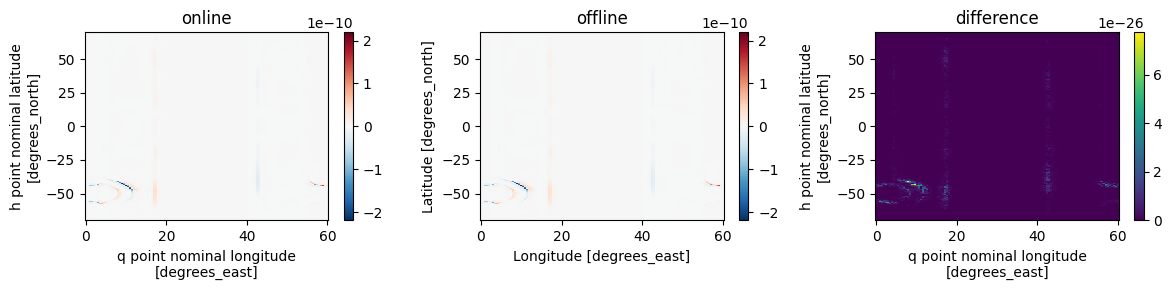

In [183]:
compare(symmetric.ZB2020u, Zanna_Bolton(symmetric,param,4,R_diss=-1.0)['ZB2020u'], param.wet_u, zl=-1)

Error: 1.3674165047290256e-43
Nans: 0


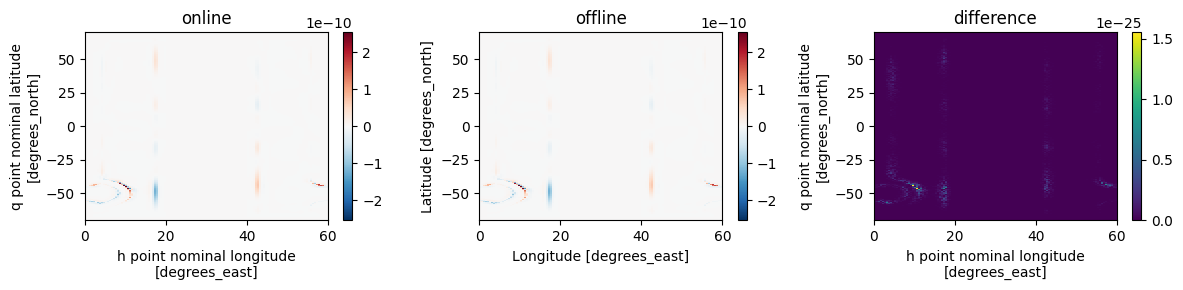

In [184]:
compare(symmetric.ZB2020v, Zanna_Bolton(symmetric,param,4,R_diss=-1.0)['ZB2020v'], param.wet_v, zl=-1)

Error: 3.960641625075784e-35
Nans: 0


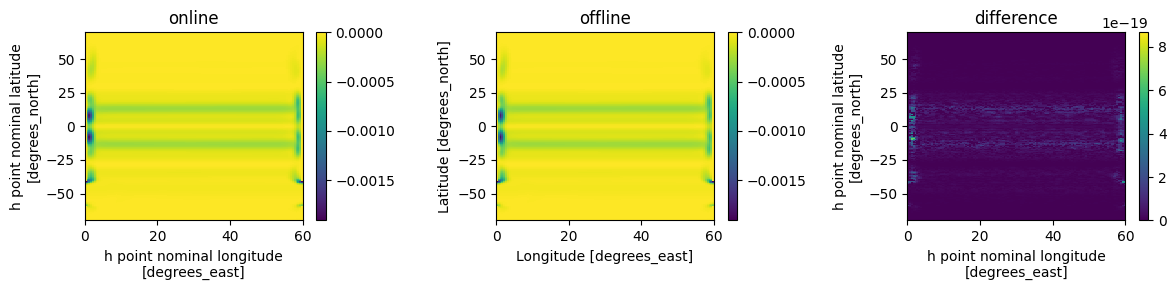

In [185]:
compare(symmetric.Txx, Zanna_Bolton(symmetric,param,4,R_diss=-1.0)['Txx'], param.wet, zl=0)

Error: 2.9620288537649114e-34
Nans: 0


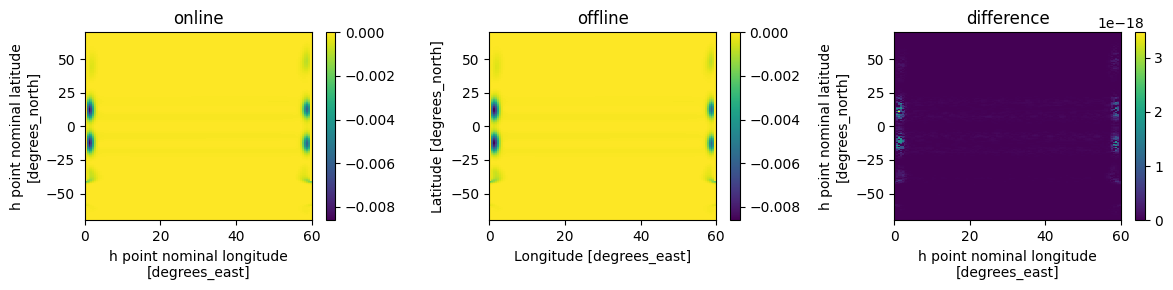

In [186]:
compare(symmetric.Tyy, Zanna_Bolton(symmetric,param,4,R_diss=-1.0)['Tyy'], param.wet, zl=0)

Error: 2.3339611776275157e-35
Nans: 0


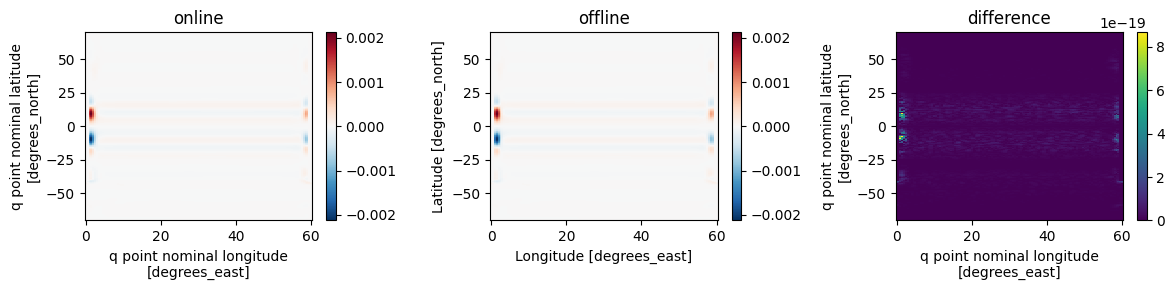

In [187]:
compare(symmetric.Txy, Zanna_Bolton(symmetric,param,4,R_diss=-1.0)['Txy'], param.wet_c, zl=0)

# Nonsymmetric

Error: 1.862034140397248e-39
Nans: 0


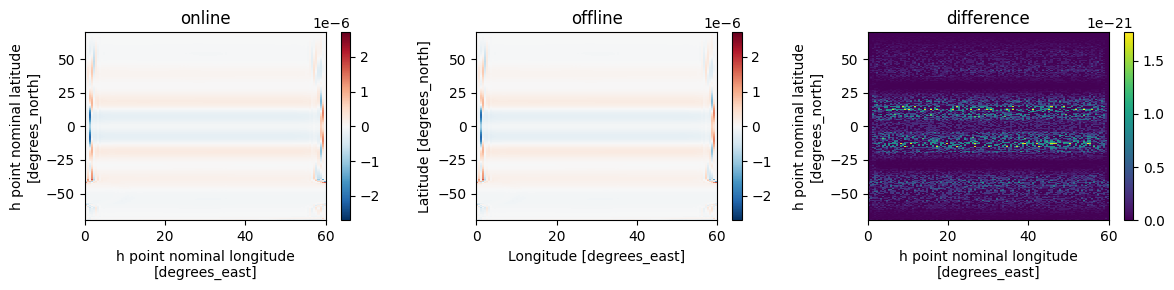

In [227]:
compare(nonsymmetric.sh_xx, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['sh_xx'], param.wet, zl=0)

Error: 2.0389798855855695e-39
Nans: 0


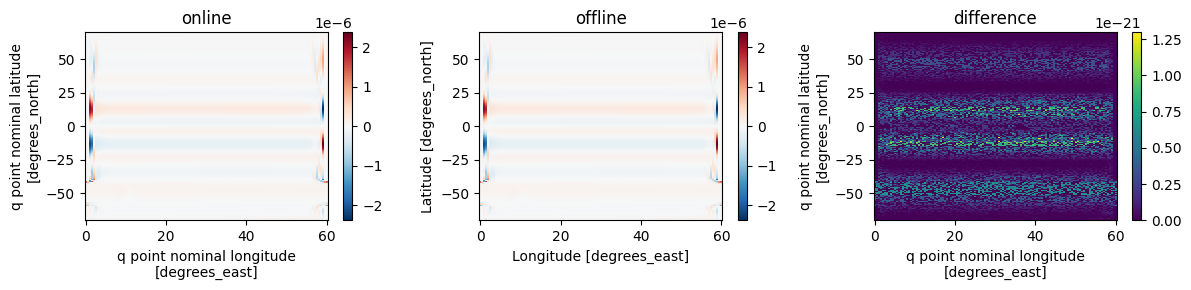

In [228]:
compare(nonsymmetric.sh_xy, Zanna_Bolton(nonsymmetric,param,0,R_diss=-1.0)['sh_xy'], param.wet_c, zl=0)

Error: 2.05271125091543e-39
Nans: 0


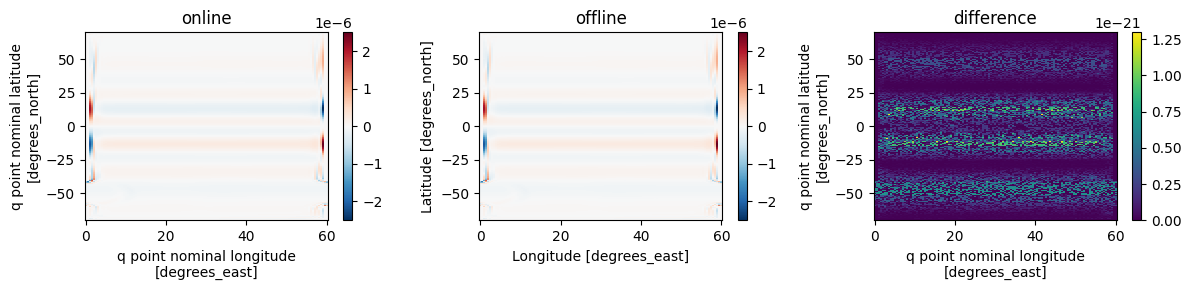

In [229]:
compare(nonsymmetric.vort_xy, Zanna_Bolton(nonsymmetric,param,0,R_diss=-1.0)['vort_xy'], param.wet_c, zl=0)

Error: 3.960641625075784e-35
Nans: 0


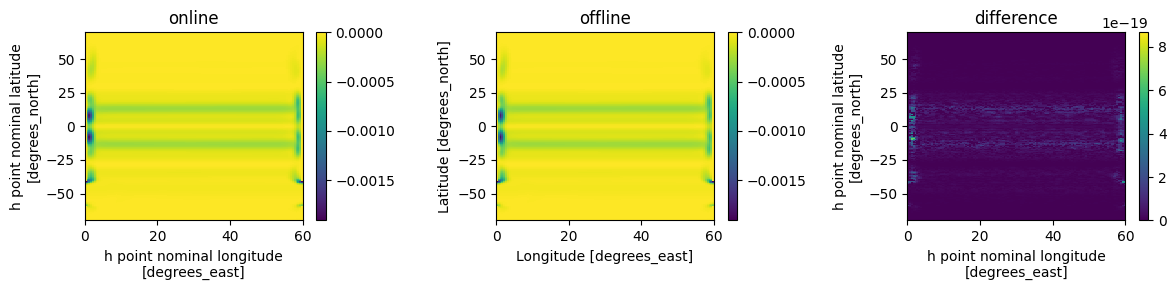

In [230]:
compare(nonsymmetric.Txx, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['Txx'], param.wet, zl=0)

Error: 2.9620288537649114e-34
Nans: 0


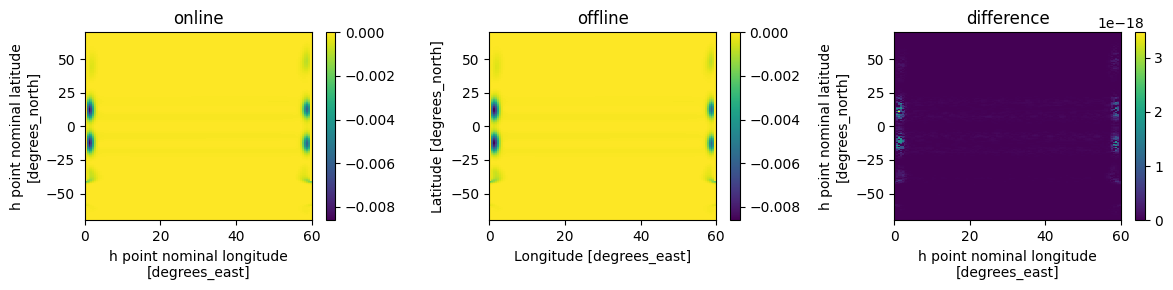

In [231]:
compare(nonsymmetric.Tyy, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['Tyy'], param.wet, zl=0)

Error: 2.3339611776275157e-35
Nans: 0


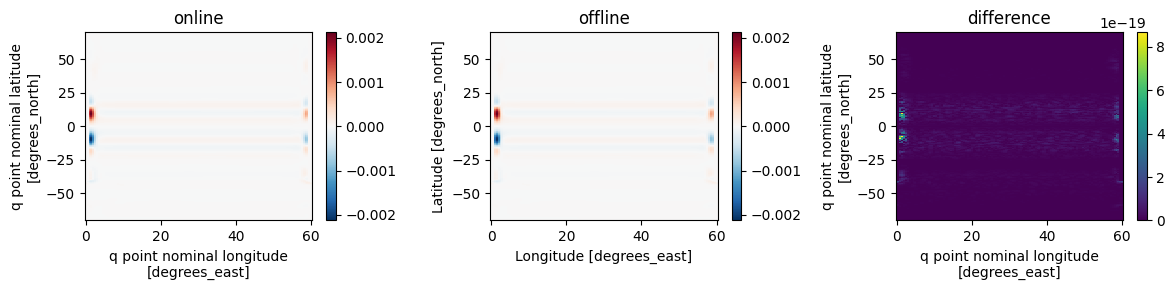

In [232]:
compare(nonsymmetric.Txy, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['Txy'], param.wet_c, zl=0)

Error: 0.0
Nans: 0


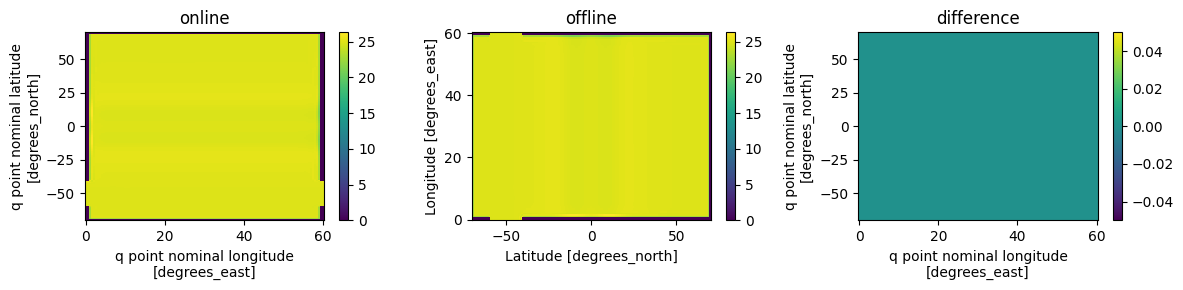

In [233]:
compare(nonsymmetric.hq, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['hq'], param.wet_c, zl=0)

Error: 2.159697301944859e-44
Nans: 0


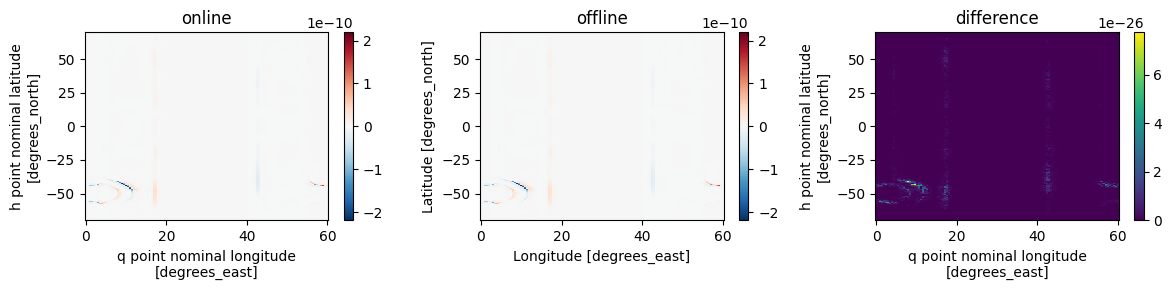

In [238]:
compare(nonsymmetric.ZB2020u, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['ZB2020u'], param.wet_u, zl=-1)

Error: 1.3674165047290256e-43
Nans: 0


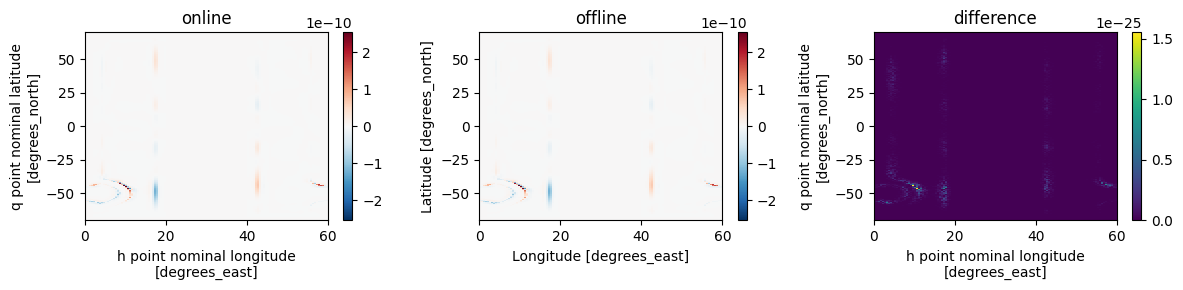

In [239]:
compare(nonsymmetric.ZB2020v, Zanna_Bolton(nonsymmetric,param,4,R_diss=-1.0)['ZB2020v'], param.wet_v, zl=-1)

# Dimensionality tests

In [30]:
dim = xr.open_dataset(f'{folder}/dim_h.nc', decode_times=False).squeeze()

In [32]:
for key in dim.variables:
    if key in ['xq', 'yq', 'xh', 'yh']:
        continue
    dim[key] = dim[key].fillna(1e+20)

Error: 2.8617412906271614e-48
Nans: 0


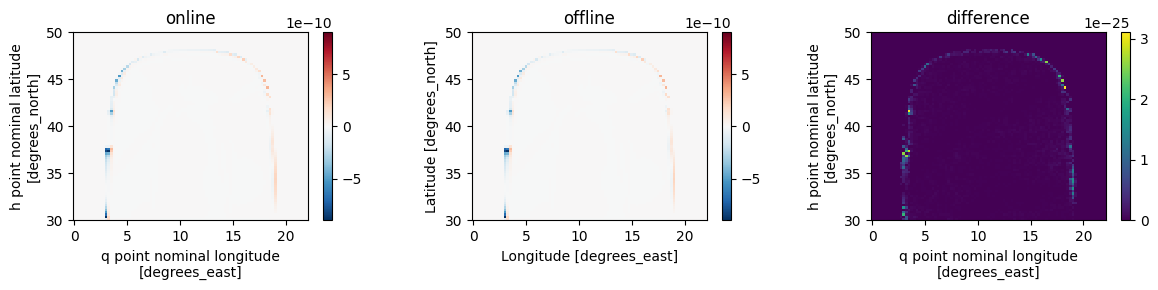

In [38]:
compare(dim.ZB2020u, Zanna_Bolton(dim,param,0,R_diss=-1.0)['ZB2020u'], param.wet_u, zl=1)

Error: 8.428317443925429e-48
Nans: 0


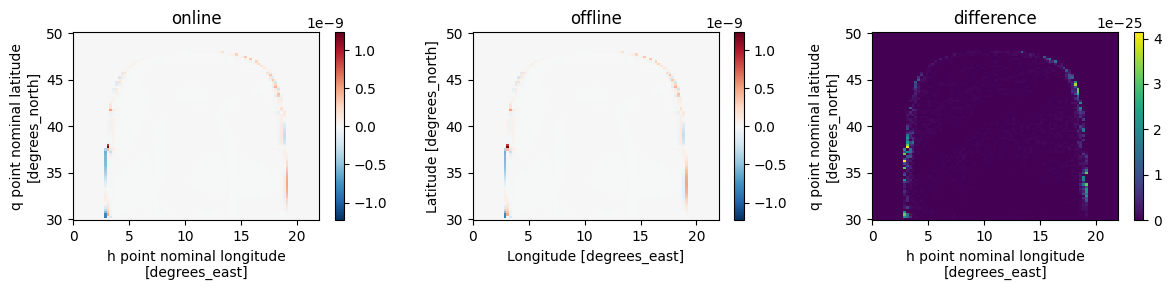

In [40]:
compare(dim.ZB2020v, Zanna_Bolton(dim,param,0,R_diss=-1.0)['ZB2020v'], param.wet_v, zl=1)

Error: 0.012113889517107294
Nans: 0


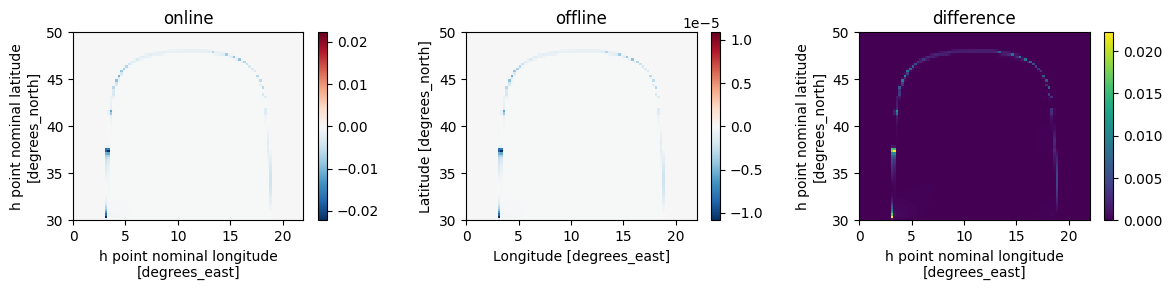

In [59]:
compare(dim.Txx, Zanna_Bolton(dim,param,0,R_diss=-1.0)['Txx'], param.wet, zl=1)

Error: 0.09607113213518836
Nans: 0


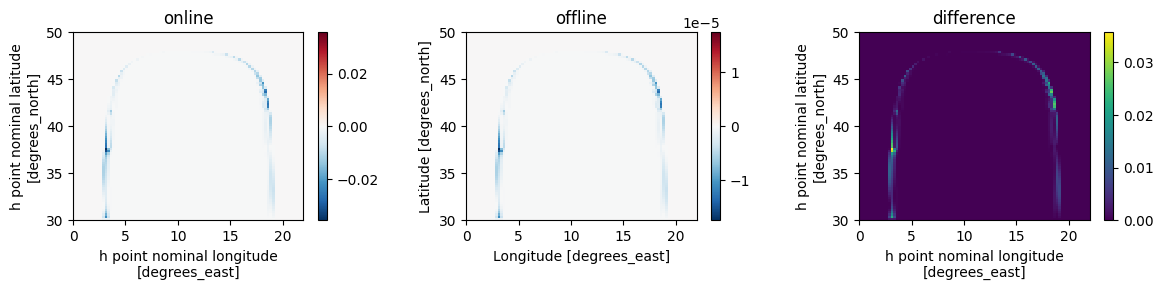

In [60]:
compare(dim.Tyy, Zanna_Bolton(dim,param,0,R_diss=-1.0)['Tyy'], param.wet, zl=1)

# First direction

In [34]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
first_y = xr.open_dataset(f'{folder}/first_y.nc', decode_times=False).squeeze()
first_x = xr.open_dataset(f'{folder}/first_x.nc', decode_times=False).squeeze()
for key in first_x.variables:
    first_x[key] = first_x[key].fillna(1e+20)
    first_y[key] = first_y[key].fillna(1e+20)

Error: 1.0474369866316572e-43
Nans: 0
Error: 1.7034113755779461e-43
Nans: 0
Error: 5.883484868509679e-29
Nans: 0


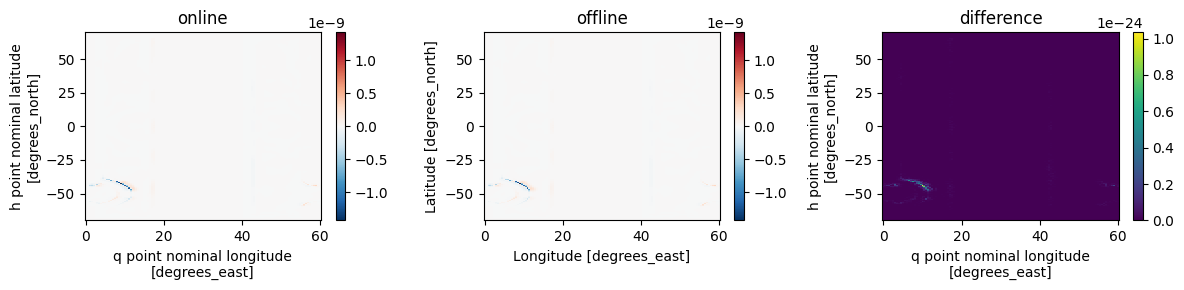

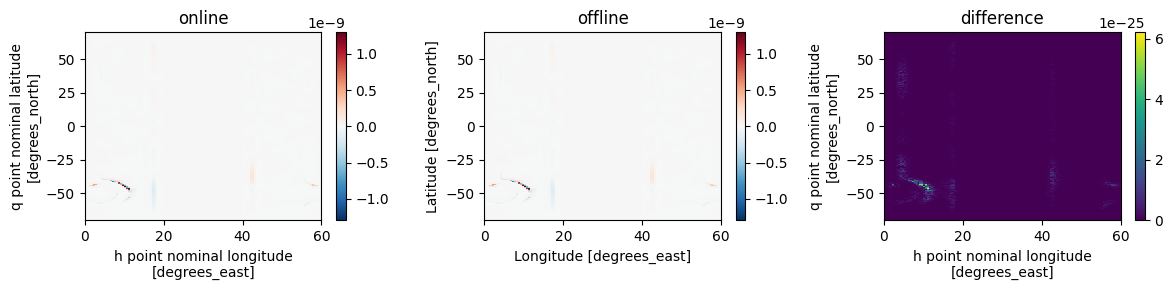

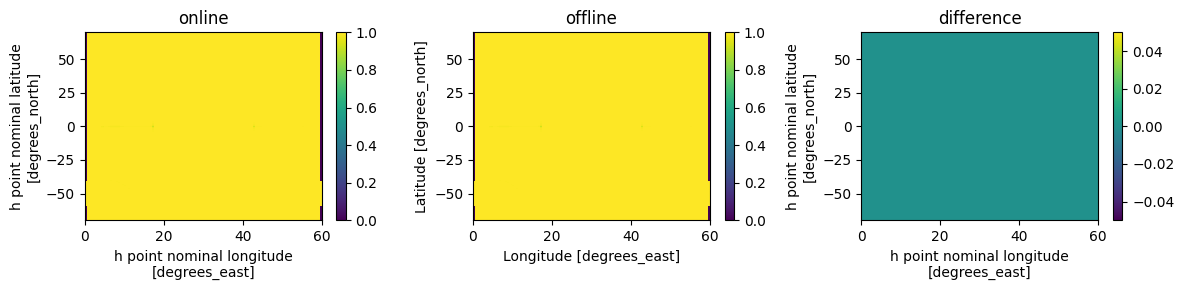

In [36]:
compare(first_x.ZB2020u, Zanna_Bolton(first_x,param,4,R_diss=1.0)['ZB2020u'], param.wet_u, zl=-1)
compare(first_x.ZB2020v, Zanna_Bolton(first_x,param,4,R_diss=1.0)['ZB2020v'], param.wet_v, zl=-1)
compare(first_x.c_diss, Zanna_Bolton(first_x,param,4,R_diss=1.0)['c_diss'], param.wet, zl=-1)

Error: 1.0970772185319894e-43
Nans: 0
Error: 1.9174698999410926e-43
Nans: 0


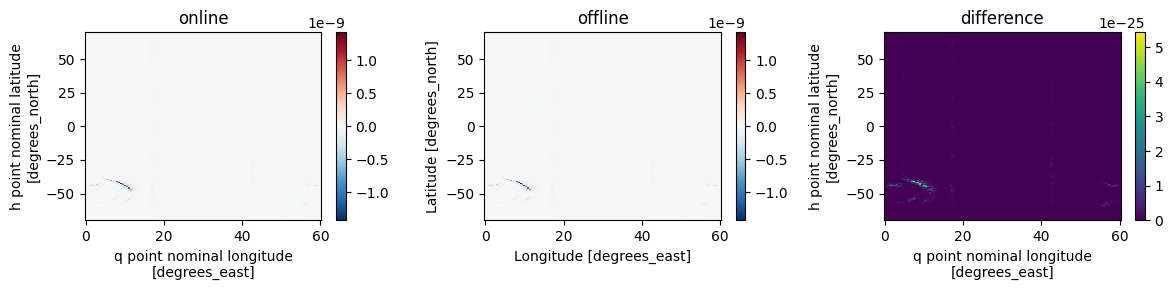

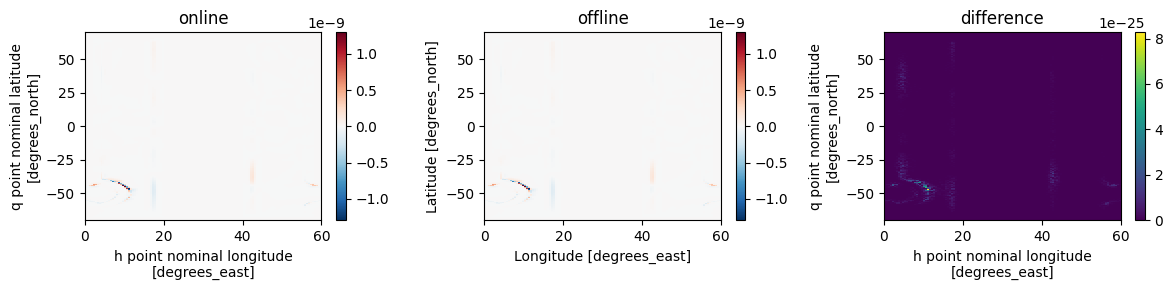

In [20]:
compare(first_y.ZB2020u, Zanna_Bolton(first_y,param,4,R_diss=1.0)['ZB2020u'], param.wet_u, zl=-1)
compare(first_y.ZB2020v, Zanna_Bolton(first_y,param,4,R_diss=1.0)['ZB2020v'], param.wet_v, zl=-1)

# Testing Reynolds

In [21]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
rey = xr.open_dataset(f'{folder}/mom_00030003.nc', decode_times=False).squeeze()
rey_pub = xr.open_dataset(f'{folder}/reynolds_pub.nc', decode_times=False).squeeze()
for key in rey_pub.variables:
    rey[key] = rey[key].fillna(1e+20)
    rey_pub[key] = rey_pub[key].fillna(1e+20)

Error: 3.5220502930457744e-38
Nans: 0
Error: 1.8239674717254204e-38
Nans: 0


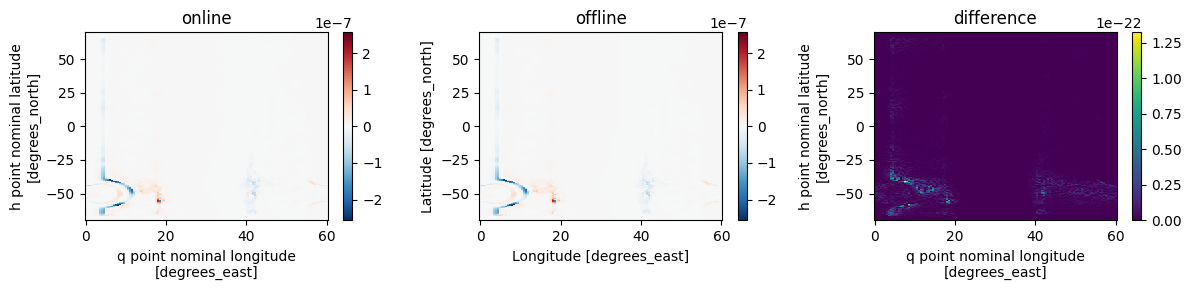

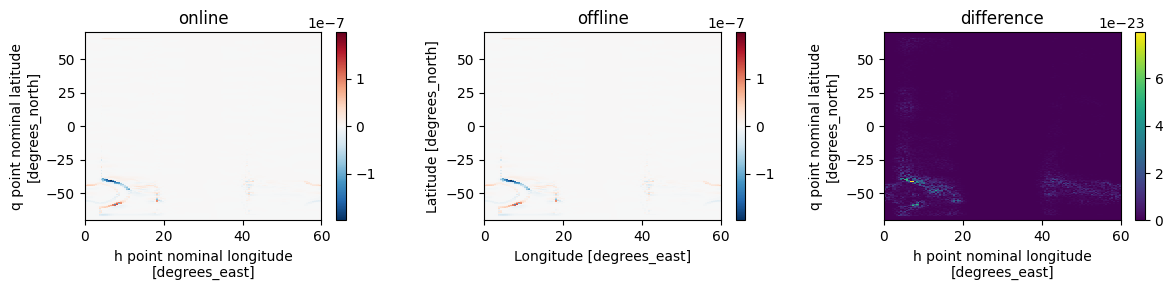

In [23]:
compare(rey.ZB2020u, Zanna_Bolton(rey,param,11,R_diss=1.0,HPF_iter=4, ZB_type=2)['ZB2020u'], param.wet_u, zl=-1)
compare(rey.ZB2020v, Zanna_Bolton(rey,param,11,R_diss=1.0,HPF_iter=4, ZB_type=2)['ZB2020v'], param.wet_v, zl=-1)

Error: 1.3648589286646417e-44
Nans: 0
Error: 3.2630714307344864e-44
Nans: 0


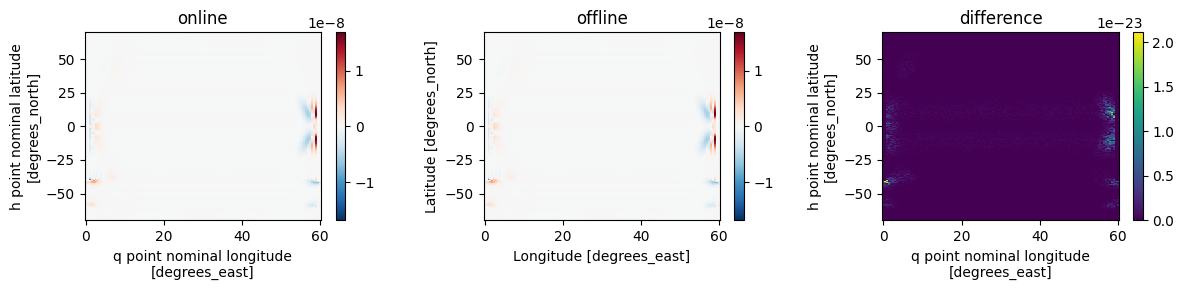

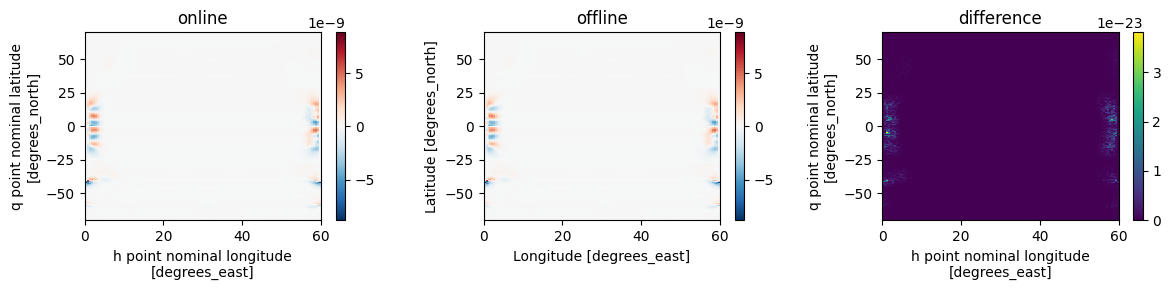

In [7]:
compare(rey_pub.ZB2020u, Zanna_Bolton(rey_pub,param,11,R_diss=1.0,HPF_iter=7)['ZB2020u'], param.wet_u, zl=0)
compare(rey_pub.ZB2020v, Zanna_Bolton(rey_pub,param,11,R_diss=1.0,HPF_iter=7)['ZB2020v'], param.wet_v, zl=0)

# Is it really conservative?

In [52]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2-R4'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

Error: 1.3073746485430594e-38
Nans: 0
Error: 9.636467048865359e-39
Nans: 0
Error: 1.1139673380711318e-35
Nans: 0


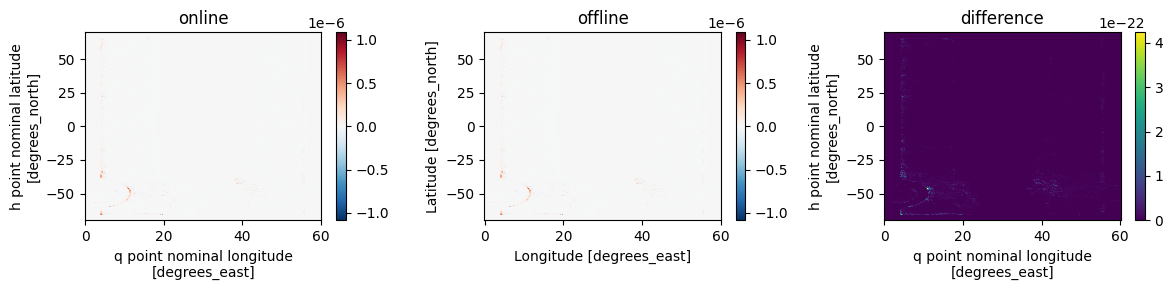

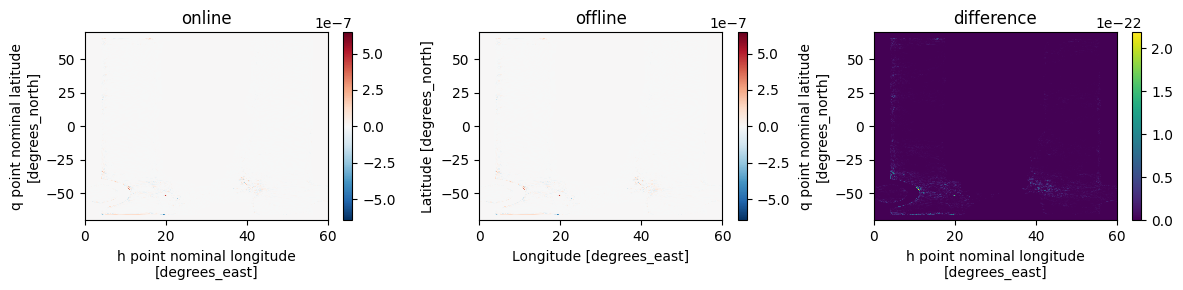

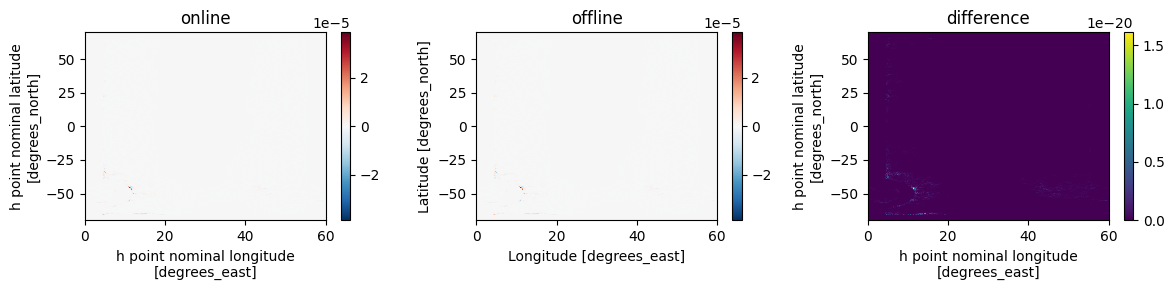

In [5]:
compare(mom.ZB2020u, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=1, amplitude=0.1)['ZB2020u'], param.wet_u, zl=-1)
compare(mom.ZB2020v, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=1, amplitude=0.1)['ZB2020v'], param.wet_v, zl=-1)
compare(mom.KE_ZB2020, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=1, amplitude=0.1)['KE_source'] / (param.area_t + 1e-70), param.wet, zl=-1)

In [28]:
for ZB_cons in [0,1]:
   print('ZB_cons Px = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=False)['Px_source'].sum().values)
   print('ZB_cons Py = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=False)['Py_source'].sum().values)

ZB_cons Px =  0 1069347.295798937
ZB_cons Py =  0 -40234846.42910546
ZB_cons Px =  1 -839359.5552655812
ZB_cons Py =  1 -38087857.85699174


In [54]:
for double_counting in [False,True]:
   print('ZB_cons Px = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=True, double_counting=double_counting)['Px_source'].sum().values)
   print('ZB_cons Py = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=True, double_counting=double_counting)['Py_source'].sum().values)

ZB_cons Px =  1 17587.124822729522
ZB_cons Py =  1 -5.3468056648853235e-09
ZB_cons Px =  1 5565.972690415823
ZB_cons Py =  1 -5.3468056648853235e-09


In [166]:
for it in [0,1,2,3,4]:
    print('Stress_iter = ', it, Zanna_Bolton(mom,param,it,R_diss=1.0,HPF_iter=0, ZB_type=0)['KE_source'].sum().values)

Stress_iter =  0 -121148418.91142258
Stress_iter =  1 -11237250.237011947
Stress_iter =  2 23103504.06851279
Stress_iter =  3 38569259.89876997
Stress_iter =  4 46653669.314204365


In [167]:
for it in [0,1,2,3,4]:
    print('Reynolds_iter = ', it, Zanna_Bolton(mom,param,it,R_diss=1.0,HPF_iter=it, ZB_type=0)['KE_source'].sum().values)

Reynolds_iter =  0 -121148418.91142258
Reynolds_iter =  1 12545867.445890151
Reynolds_iter =  2 28952130.303255074
Reynolds_iter =  3 39205080.120253555
Reynolds_iter =  4 45464129.034757994


In [262]:
for ZB_cons in [0,1,2,3]:
    print('ZB_cons = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['KE_source'].sum().values)

ZB_cons =  0 -70812433.11188972
ZB_cons =  1 48335416.14188005
ZB_cons =  2 48374418.79246396
ZB_cons =  3 48297002.52080806


## Do they conserve anything at least on uniform mesh with constant thickness?

### Uniform grid and constant thickness

In [17]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2-R4'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)
    
param = param[['wet', 'wet_c', 'wet_u', 'wet_v']]
dx = 20000.
for key in ['dxCu', 'dxCv', 'dxT', 'dxBu', 'dyCu', 'dyCv', 'dyT', 'dyBu']:
    param[key] = dx
for key in ['area_t', 'area_u', 'area_v', 'area_q']:
    param[key] = dx * dx
mom['h'] = (mom['h'] * param.wet).sum(('xh', 'yh')) / (param.wet).sum(('xh', 'yh')) + mom['h'] * 0

In [20]:
for ZB_cons in [0,1,2,3]:
    print('ZB_cons KE = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['KE_source'].sum().values)
#    print('ZB_cons Px = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['Px_source'].sum().values)
#    print('ZB_cons Py = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['Py_source'].sum().values)

ZB_cons KE =  0 -623692314.3865604
ZB_cons KE =  1 -2.7628573207039153e-08
ZB_cons KE =  2 -1.9420383523538476e-08
ZB_cons KE =  3 -5.981814865663182e-08


In [22]:
for ZB_cons in [0,1]:
   print('ZB_cons Px = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=True)['Px_source'].sum().values)
   print('ZB_cons Py = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=True)['Py_source'].sum().values)

ZB_cons Px =  0 3.451714292168617e-08
ZB_cons Py =  0 -1.0766370905912481e-08
ZB_cons Px =  1 3.451714292168617e-08
ZB_cons Py =  1 -1.0766370905912481e-08


In [23]:
for ZB_cons in [0,1]:
   print('ZB_cons Px = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=False)['Px_source'].sum().values)
   print('ZB_cons Py = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=0, ZB_cons=ZB_cons, Txy_only=False)['Py_source'].sum().values)

ZB_cons Px =  0 -396696.31125378585
ZB_cons Py =  0 626875.8485279661
ZB_cons Px =  1 -2264539.418936198
ZB_cons Py =  1 624547.1854608722


### Just uniform grid

In [284]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2-R4'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)
    
param = param[['wet', 'wet_c', 'wet_u', 'wet_v']]
dx = 20000.
for key in ['dxCu', 'dxCv', 'dxT', 'dxBu', 'dyCu', 'dyCv', 'dyT', 'dyBu']:
    param[key] = dx
for key in ['area_t', 'area_u', 'area_v', 'area_q']:
    param[key] = dx * dx

In [285]:
for ZB_cons in [0,1,2,3]:
    print('ZB_cons = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['KE_source'].sum().values)

ZB_cons =  0 -80888180.07852684
ZB_cons =  1 73618921.29089777
ZB_cons =  2 73618921.29089777
ZB_cons =  3 73618921.29089779


### Just constant thickness

In [24]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2-R4'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)
    
mom['h'] = (mom['h'] * param.wet).sum(('xh', 'yh')) / (param.wet).sum(('xh', 'yh')) + mom['h'] * 0

In [25]:
for ZB_cons in [0,1,2,3]:
    print('ZB_cons = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['KE_source'].sum().values)

ZB_cons =  0 -433423825.506165
ZB_cons =  1 -97070.06027424979
ZB_cons =  2 -191373.16829816138
ZB_cons =  3 6.396589924406726e-09


### Constant kappa_bc

In [294]:
amp = param.area_t.mean()
for ZB_cons in [0,1,2,3]:
    print('ZB_cons = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=-1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons, amp=amp)['KE_source'].sum().values)

ZB_cons =  0 -654681689.9035902
ZB_cons =  1 -3.524144176481059e-08
ZB_cons =  2 -144762.82533165647
ZB_cons =  3 148801.92888738107


### However, once we introduce additional attenuation function, this difference is negligible.

In [288]:
for ZB_cons in [0,1,2,3]:
    print('ZB_cons = ', ZB_cons, Zanna_Bolton(mom,param,0,R_diss=1.0,HPF_iter=0, ZB_type=1, ZB_cons=ZB_cons)['KE_source'].sum().values)

ZB_cons =  0 -393489697.3647398
ZB_cons =  1 -17895843.11437089
ZB_cons =  2 -17996502.131032985
ZB_cons =  3 -17792957.29413879


# To sum up
* Together with our "energy-conserving" scheme, we can consider two additional: without weighting with grid steps and with quadratic weighting
* When grid is uniform, all three schemes are equivalent and conservative compared to the simple scheme.
* On non-uniform grid and constant thickness, the scheme with quadratic weighting is numerically conservative, while two others reduce energy contribution 1e+4 times
* When thickness and grid step are varying, all three schemes have similar energetic effect
* The energetic effect from varying grid step is much less compared to the contribution from the varying thickness
* It makes sense for backward compatibility to keep our scheme which accounts only for different grid spacing of different amplitude (this cannot be figured out) but not both.
* Note that we can claim that we account only for the grid metrics but not changing amplitude. The amplitude can be changed by different factors. For example, R_diss. Every such factor would require to change the discretization. Which seems not reasonable. We want to use a single discretization for all cases independent of the amplitude. 
* **Our scheme conserves energy exactly on nonuniform grid under assumption of constant parameterization amplitude}**
* **Momentum is conserved only if Txx=0 and Tyy=0. Otherwise there are contributions from these tensors to integral of momentum change. Also, non-uniform grid results to non-conservation.**